# Polynomial Linear Regression with the Neighbourhood Algorithm

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

## Table of contents

1. [Introduction](#introduction)
   1. [Neighbourhood Algorithm](#na)
   2. [CoFI and the NA](#cofiandna)
   3. [Problem](#problem)
2. [Import Modules and Plot Functions](#import)
3. [Define the problem](#problemsetup)
4. [Straight Up NA](#neighpy)
5. [Just the Direct Search](#directsearch)
6. [Just the Appraisal](#appraisal)
   1. [Using the Direct Search samples](#appraisal_ds)
   2. [Using the samples from somewhere else](#appraisal_emcee)


---

## 1. Introduction <a name="introduction"></a>

### 1.1 Neighbourhood Algorithm <a name="na"></a>

The Neighbourhood Algorithm (NA) is described in two papers ([Sambridge, 1999a]() and [Sambridge, 1999b]()) and became popular for geophysical inverse problems.
We give a breif summary of the NA here for intuition.

It can be divided into two main phases:
1. Direct Search Phase
2. Appraisal Phase

As decribed in the papers, these phases use geometrical structures called Voronoi cells to define neighbourhoods of parameter space within which the value of the objective function is constant.
These neighbourhoods are then repeatedly sampled and refined to find the optimum position in the parameter space.

#### Direct Search Phase

This is a derivative-free optimisation aglorithm that results in an ensemble of points/samples/neighbourhoods distributed according to the objective function being solved.
More dense regions of points correspond to the more optimum areas of the objective function.

In brief, the phase algorithm progresses as follows:
1. Create an initial ensemble (of size $n_i$) of points by uniformly sampling the parameter space
2. Interate $n$ times:
   1. Rank the ensemble according to the objective function
   2. Select the best $n_r$ points in the ensemble to be resampled
   3. Resample the neighbourhoods/Voronoi cells of best $n_r$ points to obtain $n_s$ new samples
   4. Add the new samples to the ensemble

In the original papers the resampling is performed using a Gibbs sampler, although in theory any sampling algorithm can be used within each neighbourhood - the trick is in computing the neighbourhoods.

The result of this phase is a large ensemble of size $N = n_i + n \times n_s$ and their associated objective values, effectivly a discretisation of the objective function.

#### Appraisal Phase

This phase is used to reffine an ensemble of points, and produce new samples that are distributed according to the posterior distribution function.
Effectively, this is just a Bayesian sampling of a step-wise constant posterior.
In theory any sampling approach can be used to create the ensemble to be refined, and any sampling approach can be used to do the refining.
In the original papers the initial ensemble is created using the Direct Search Phase, and the refining is done with a Gibbs sampler.

A key advantage of this phase is that it avoids computing the forward function for all the new samples.
So if you have already partially sampled the parameter space but the forward function is too slow that your initial method will take too long to get a sufficient number of samples, you can use the appraisal phase of the NA.

### 1.2 CoFI and the NA <a name="cofiandna"></a>

The implementation of the NA that `cofi` wraps is called [`neighpy`]().
This implementation implements both phases of the NA as describled in the original papers.

Because of the multi-phase nature of the NA, `cofi` gives you 3 options:
1. Only run the Direct Search Phase
2. Only run the Appraisal Phase, using samples obtained from any method
3. Run both phases, using the Direct Seach Phase samples as the initial ensemble for the Appraisal Phase

We will look at all of these options in this tutorial.


### 1.3 Problem <a name="problem"></a>

This tutorial focusses on linear regression - that is, fitting curves to datasets.

We will work with polynomial curves, $$y(x) = \sum_{n=0}^N m_n x^n\,.$$
Here, $N$ is the 'order' of the polynomial: if N=1 we have a straight line, if N=2 it will be a quadratic, and so on. The $m_n$ are the 'model coefficients'.


We have a set of noisy data values, Y, measured at known locations, X, and wish to find the best fit degree 3 polynomial.

The function we are going to fit is: $y=-6-5x+2x^2+x^3$

---

## 2. Import Modules and Plot Functions<a name="import"></a>

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from functools import partial
from numbers import Number

from cofi import BaseProblem, InversionOptions, Inversion

np.random.seed(42)

In [3]:
############## PLOTTING ###############################################################
def _add_extra(plot_fn, extra):
    # plot_fn = ax.plot, ax.scatter ....
    # extra = [x, y, kwargs]
    try:
        kwargs = extra[2]
    except IndexError:
        kwargs = {}
    plot_fn(extra[0], extra[1], **kwargs)

def plot_data_space(basis_func, _m_true, x, y_observed, sigma, samples=None, samples_label="", extras=None):
    # extras = [[model, kwargs], ...]
    _x_plot = np.linspace(-3.5, 2.5)
    _G_plot = basis_func(_x_plot)
    fig, ax = plt.subplots(figsize=(12, 5))
    if samples is not None:
        ax.plot(
            _x_plot,
            np.apply_along_axis(lambda m: _G_plot @ m, 1, samples).T,
            color="k",
            alpha=0.1,
            label=samples_label,
        )
    if extras is not None:
        for extra in extras:
            _y_plot = _G_plot @ extra[0]
            _add_extra(ax.plot, [_x_plot, _y_plot, extra[1]])  # [x, y, kwargs]

    _y_plot = _G_plot @ _m_true
    ax.plot(_x_plot, _y_plot, color="r", label="True model")
    ax.errorbar(
        x, y_observed, yerr=sigma, fmt=".", color="lightcoral", label="observed data"
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_ylim(-11, 10)
    handles, labels = [x[-5:] for x in ax.get_legend_handles_labels()]
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

def plot_direct_search_evolution(objectives, n_initial, n_total):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(objectives, marker=".", linestyle="", markersize=2, color="black")
    ax.set_yscale("log")
    ax.set_xlabel("Sample number")
    ax.set_ylabel("Objective value")
    ax.set_title("Evolution of the objective function during the direct search")
    ax.plot(
        [0, n_initial],
        [1e1, 1e1],
        linestyle="--",
        color="gray",
        marker="|",
        markersize=10,
    )
    ax.plot(
        [n_initial, n_total],
        [1e1, 1e1],
        linestyle="--",
        color="gray",
        marker="|",
        markersize=10,
    )
    ax.text(n_initial // 2, 1e1, "Initial random search", ha="center", va="bottom")
    ax.text(
        n_initial + (n_total - n_initial) // 2,
        1e1,
        "Optimisation search",
        ha="center",
        va="bottom",
    )

def plot_direct_search_marginals(_m_true, bounds, ds_voronoi, extras=[]):
    # extras = [[model, kwargs], ...]
    fig, axs = plt.subplots(
        3, 3, figsize=(7, 7), tight_layout=True, gridspec_kw={"hspace": 0, "wspace": 0}
    )
    for i in range(1, 4):
        for j in range(3):
            if j < i:
                vor = Voronoi(ds_voronoi[:, [i, j]])
                voronoi_plot_2d(
                    vor,
                    ax=axs[i - 1, j],
                    show_vertices=False,
                    show_points=False,
                    line_width=0.1,
                )
                axs[i - 1, j].scatter(
                    _m_true[i],
                    _m_true[j],
                    c="r",
                    marker="x",
                    s=100,
                    label="True model",
                    zorder=10,
                )
                for extra in extras:
                    m, kwargs = extra
                    _add_extra(axs[i - 1, j].scatter, [m[i], m[j], kwargs]) # [x, y, kwargs]
                axs[i - 1, j].set_xlim(bounds[i])
                axs[i - 1, j].set_ylim(bounds[j])
                if j == 0:
                    axs[i - 1, j].set_ylabel(f"$m_{i}$")
                else:
                    axs[i - 1, j].set_yticks([])
                if i == 3:
                    axs[i - 1, j].set_xlabel(f"$m_{j}$")
                else:
                    axs[i - 1, j].set_xticks([])
            else:
                axs[i - 1, j].set_visible(False)
    handles, labels = axs[1, 0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(
        by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0.4, 0.65)
    )
    fig.suptitle("Direct Search Phase Results")

def plot_appraisal_marginals(_m_true, bounds, appraised, extras=[]):
    appraised_mean = appraised.mean(axis=0)
    fig, axs = plt.subplots(
        4, 4, figsize=(7, 7), tight_layout=True, gridspec_kw={"hspace": 0, "wspace": 0}
    )
    for i in range(4):
        for j in range(4):
            if j == i:
                axs[i, j].hist(appraised[:, i], bins=20, histtype="step", color="k", label="Appraisal samples")
                axs[i, j].axvline(appraised_mean[i], color="b", linestyle="--", label="Appraisal mean")
                axs[i, j].axvline(_m_true[i], color="r", linestyle="--", label="True model")
                for extra in extras:
                    m, _kwargs = extra
                    kwargs = {"linestyle": "--"}
                    if "color" in _kwargs.keys():
                        kwargs = {**kwargs, "color":_kwargs["color"]}
                    axs[i, j].axvline(m[i], **kwargs)
                axs[i, j].set_xlim(bounds[i])
                axs[i, j].set_yticks([])
            elif j < i:
                axs[i, j].scatter(
                    appraised[:, i],
                    appraised[:, j],
                    c="gray",
                    s=0.1,
                    label="Appraisal samples",
                )
                axs[i, j].scatter(
                    appraised_mean[i],
                    appraised_mean[j],
                    c="b",
                    marker="x",
                    s=100,
                    label="Appraisal mean",
                    zorder=10,
                )
                axs[i, j].scatter(
                    _m_true[i],
                    _m_true[j],
                    c="r",
                    marker="x",
                    s=100,
                    label="True model",
                    zorder=10,
                )
                for extra in extras:
                    m, kwargs = extra
                    _add_extra(axs[i, j].scatter, [m[i], m[j], kwargs]) # [x, y, kwargs]
                axs[i, j].set_xlim(bounds[i])
                axs[i, j].set_ylim(bounds[j])
            else:
                axs[i, j].set_visible(False)
            if j == 0:
                if i != 0:
                    axs[i, j].set_ylabel(f"$m_{i}$")
            else:
                axs[i, j].set_yticks([])
            if i == 3:
                axs[i, j].set_xlabel(f"$m_{j}$")
            else:
                axs[i, j].set_xticks([])
    handles, labels = axs[1, 0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(
        by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0.535, 0.51)
    )
    fig.suptitle("Appraisal Phase Results")


---

## 3. Define the problem <a name="problemsetup"></a>

Here we compute $y(x)$ for multiple $x$-values simultaneously, so write the forward operator
in the following form:

$$ \left(\begin{array}{c}y_1\\y_2\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_1&x_1^2&x_1^3\\1&x_2&x_2^2&x_2^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$

This clearly has the required general form, $\mathbf{y=Gm}$, and so the best-fitting model can be identified using the least-squares algorithm.

In the following code block, we'll define the forward function and generate some random
data points as our dataset.

$$
\begin{align}
\text{forward}(\textbf{m}) &= \textbf{G}\textbf{m}\\
&= \text{basis\_func}(\textbf{x})\cdot\textbf{m}
\end{align}
$$

where:

- $\text{forward}$ is the forward function that takes in a model and produces synthetic data,
- $\textbf{m}$ is the model vector,
- $\textbf{G}$ is the basis matrix (i.e. design matrix) of this linear regression problem and looks like the following:
$$\left(\begin{array}{ccc}1&x_1&x_1^2&x_1^3\\1&x_2&x_2^2&x_2^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)$$
- $\text{basis\_func}$ is the basis function that converts $\textbf{x}$ into $\textbf{G}$

Recall that the function we are going to fit is: $y=-6-5x+2x^2+x^3$

In [4]:
# generate data with random Gaussian noise
def basis_func(x):
    return np.array([x**i for i in range(4)]).T  # x -> G


_m_true = np.array([-6, -5, 2, 1])  # m
sample_size = 20  # N
x = np.random.choice(np.linspace(-3.5, 2.5), size=sample_size)  # x


def forward_func(m):
    return basis_func(x) @ m  # m -> y_synthetic

sigma = 1
Cd = np.eye(sample_size) * sigma**2  # Cd
y_observed = forward_func(_m_true) + np.random.normal(0, sigma, sample_size)  # d


In [5]:
# quickly redefining some plot functions
plot_data_space = partial(plot_data_space, basis_func=basis_func, _m_true=_m_true, x=x, y_observed=y_observed, sigma=sigma)

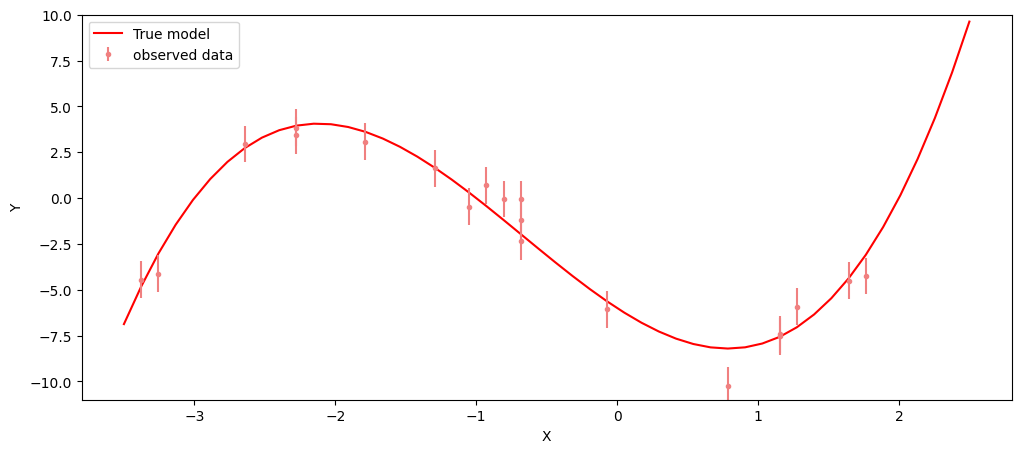

In [6]:
plot_data_space()

We will use a simple weighted $\ell_2$-norm misfit as our objective function

$$ F(\mathbf{m}) = (\mathbf{d} - \mathbf{Gm})^T\mathbf{C_d}^{-1}(\mathbf{d} - \mathbf{Gm}) $$

where $\mathbf{d}$ is the observed data vector and $\mathbf{C_d}$ is the data covariance matrix.

In [7]:
Cd_inv = np.linalg.inv(Cd)

def objective(m: np.ndarray) -> Number:
    y_predicted = forward_func(m)
    return (y_observed - y_predicted).T @ Cd_inv @ (y_observed - y_predicted)

In [8]:
# define the problem in cofi
inv_problem = BaseProblem()
inv_problem.name = "Polynomial Regression"
inv_problem.set_data(y_observed)
inv_problem.set_objective(objective)

inv_problem.summary()

Summary for inversion problem: Polynomial Regression
Model shape: Unknown
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'data']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
-- none --
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data_covariance', 'data_covariance_inv', 'initial_model', 'model_shape', 'blobs_dtype', 'bounds', 'constraints']


---

## 4. Straight Up NA <a name="neighpy"></a>

Here we'll just run both phases of the NA in one go.

For this we use the `cofi` tool called `Neighpy`.

In [9]:
bounds=[[-10, 10]] * 4  # some loose prior bounds on all the polynomial coefficients
n_samples_per_iteration=100  # number of samples to draw per iteration
n_cells_to_resample=20  # number of cells to resample - the larger this is the more the algorithm will explore
n_initial_samples=5000  # number of initial samples to draw
n_iterations=100  # number of iterations (direct search) to run
n_resample=1000  # number of resamples to draw from appraisal
n_walkers=5  # number of walkers for the appraisal

inv_options = InversionOptions()
inv_options.set_tool("neighpy")
inv_options.set_params(
    bounds=bounds,
    n_samples_per_iteration=n_samples_per_iteration,
    n_cells_to_resample=n_cells_to_resample,
    n_initial_samples=n_initial_samples,
    n_iterations=n_iterations,
    n_resample=n_resample,
    n_walkers=n_walkers,
)

In [10]:
# quickly redefining some plot functions
plot_direct_search_marginals = partial(plot_direct_search_marginals, _m_true=_m_true, bounds=bounds)
plot_appraisal_marginals = partial(plot_appraisal_marginals, _m_true=_m_true, bounds=bounds)

In [11]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()
inv_result.summary()

ValueError: you've chosen Neighpy to be your solving tool, but not enough information is provided in the InversionOptions object - required: {'direct_search_nr', 'direct_search_ni', 'bounds', 'appraisal_n_resample', 'appraisal_n_walkers', 'direct_search_n', 'direct_search_ns'}; provided: {'bounds': [[-10, 10], [-10, 10], [-10, 10], [-10, 10]], 'n_samples_per_iteration': 100, 'n_cells_to_resample': 20, 'n_initial_samples': 5000, 'n_iterations': 100, 'n_resample': 1000, 'n_walkers': 5}

The `InversionResult` object from an `Inversion` with the `Neighpy` tool contains the following results
- `model` - the best fitting model from the direct search phase
- `direct_search_samples`
- `direct_search objectives`
- `appraisal_samples`

In [ ]:
best = inv_result.model
ds_voronoi = inv_result.direct_search_samples
ds_objs = inv_result.direct_search_objectives
appraised = inv_result.appraisal_samples
appraised_mean = inv_result.appraisal_samples.mean(axis=0)

We can see how the objective function is optimised during the direct search phase by looking at the evolution of the objective value as the iterations progress

In [ ]:
plot_direct_search_evolution(
    ds_objs,
    n_initial_samples,
    n_initial_samples + n_iterations * n_samples_per_iteration,
)

To plot the results we can look at the 2D projections of the parameter space, as well as the data space predictions

In [ ]:
plot_direct_search_marginals(ds_voronoi=ds_voronoi, extras=[[best, {"label":"Best Model", "color":"g", "marker":"x", "s": 100}]])

In [ ]:
plot_appraisal_marginals(appraised=appraised, extras=[[best, {"label":"Best Model", "color":"g", "marker":"x", "s": 100}]])

In [ ]:
plot_data_space(
    samples=appraised,
    samples_label="Appraisal samples",
    extras=[
        [best, {"label": "Best model", "color": "g"}],
        [appraised_mean, {"label": "Appraisal mean", "color": "b"}],
    ],
)

---

## 5. Just the Direct Search <a name=directsearch></a>

If you just want to optimise the objective function and find a point estimate, you can just run the direct search phase.

In `cofi` this is implemented in the `NeighpyI` tool.  The results here should be very similar to the direct search results of `Neighpy` above.

In [ ]:
bounds=[[-10, 10]] * 4  # some loose prior bounds on all the polynomial coefficients
n_samples_per_iteration=100  # number of samples to draw per iteration
n_cells_to_resample=20  # number of cells to resample - the larger this is the more the algorithm will explore
n_initial_samples=5000  # number of initial samples to draw
n_iterations=100  # number of iterations (direct search) to run

inv_options = InversionOptions()
inv_options.set_tool("neighpyI")
inv_options.set_params(
    bounds=bounds,
    n_samples_per_iteration=n_samples_per_iteration,
    n_cells_to_resample=n_cells_to_resample,
    n_initial_samples=n_initial_samples,
    n_iterations=n_iterations,
    serial=False
)

inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()
inv_result.summary()
best = inv_result.model
ds_voronoi = inv_result.samples
ds_objs = inv_result.objectives

In [ ]:
plot_direct_search_marginals(ds_voronoi=ds_voronoi, extras=[[best, {"label":"Best Model", "color":"g", "marker":"x", "s": 100}]])

---

## 6. Just the Appraisal <a name="appraisal"></a>

The appraisal phase is implemented in the `cofi` tool `NeighpyII` and takes a set of samples and their corresponding log posterior.


### 6.1 Using the Direct Search samples <a name="appraisal_ds"></a>

There's a little subtlety here in that the Direct Search _minimises_ an objective function, but the appraisal _maximises_ a posterior.
The objective function we're using here corresponds to the _negative log-likelihood_ of a Gaussian distribution, so when we pass the outputs of the direct seach phase we need to multiply by -1.
The `Neiphy` tool we used earlier does this under the hood.

In [ ]:
inv_options = InversionOptions()
inv_options.set_tool("neighpyII")
inv_options.set_params(
    bounds=bounds,
    initial_ensemble=ds_voronoi,  # ensemble from the direct search
    log_ppd=-ds_objs,  # negative of the objective function for the direct search ensemble
    n_resample=n_resample,
    n_walkers=n_walkers,
)

inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()
inv_result.summary()
appraised = inv_result.new_samples
appraised_mean = inv_result.new_samples.mean(axis=0)

In [ ]:
plot_appraisal_marginals(appraised=appraised, extras=[[best, {"label":"Best Model", "color":"g", "marker":"x", "s": 100}]])

In [ ]:
plot_data_space(
    samples=appraised,
    samples_label="Appraisal samples",
    extras=[
        [best, {"label": "Best model", "color": "g"}],
        [appraised_mean, {"label": "Appraisal mean", "color": "b"}],
    ],
)

### 6.2 Using samples from somewhere else <a name="appraisal_emcee"></a>

Nothing forces use to use NA Direct Search Phase samples to feed the Appraisal Phase!

Here we use a small set of samples from the `emcee` sampler as our initial appraisal ensemble.
We'll just pretend that we have a slow forward model and using `emcee` on its own will take too long.
(We'll use `cofi` to get the `emcee` samples!)

In [ ]:
# Get initial ensemble from emcee

def log_likelihood(m):
    return -0.5 * objective(m)


def log_prior(m):
    for _m, (l, u) in zip(m, bounds):
        if _m < l or _m > u:
            return -np.inf  # model lies outside bounds -> return log(0)
    return 0.0  # model lies within bounds -> return log(1)

nwalkers = 8
ndim = 4
nsteps = 10000
walkers_start = np.array([0.,0.,0.,0.]) + np.random.randn(nwalkers, ndim)

inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

inv_options = InversionOptions()
inv_options.set_tool("emcee")
inv_options.set_params(nwalkers=nwalkers, nsteps=nsteps, initial_state=walkers_start)

inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

emcee_samples = inv_result.sampler.get_chain(flat=True)
emcee_logppd = inv_result.sampler.get_log_prob(flat=True)

In [ ]:
# Appraise the emcee ensemble

inv_options = InversionOptions()
inv_options.set_tool("neighpyII")
inv_options.set_params(
    bounds=bounds,
    initial_ensemble=emcee_samples,
    log_ppd=emcee_logppd,
    n_resample=n_resample,
    n_walkers=n_walkers,
)

inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()
inv_result.summary()
appraised = inv_result.new_samples
appraised_mean = inv_result.new_samples.mean(axis=0)

In [ ]:
plot_appraisal_marginals(appraised=appraised, extras=[])

In [ ]:
plot_data_space(
    samples=appraised,
    samples_label="Appraisal samples",
    extras=[
        [appraised_mean, {"label": "Appraisal mean", "color": "b"}],
    ],
)

---

## Watermark

In [ ]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))